In [41]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler

postgresql_jdbc_jar = r"C:/Program Files/PostgreSQL/17/postgresql-42.7.4.jar"
spark = SparkSession.builder.appName('modeldevelopment')\
                            .config("spark.jars", postgresql_jdbc_jar) \
                            .config("spark.driver.extraClassPath", postgresql_jdbc_jar) \
                            .config("spark.driver.memory", "8g")\
                            .config("spark.executor.memory", "8g")\
                            .config("spark.executor.cores", "4")\
                            .getOrCreate()

### Reading the data

In [42]:
# Database connection parameters
url = "jdbc:postgresql://localhost:5432/postgres"
properties = {
    "user": "postgres",
    "password": "root",
    "driver": "org.postgresql.Driver"
}

# Load the data into a PySpark DataFrame
df_model = spark.read.jdbc(url=url, table='feature_engineering_pickup', properties=properties)

In [5]:
df_model.printSchema()

root
 |-- pickup_time: timestamp (nullable = true)
 |-- accept_time: timestamp (nullable = true)
 |-- is_delayed: string (nullable = true)
 |-- speed_status: string (nullable = true)
 |-- speed_kmh: double (nullable = true)
 |-- city_order_count: double (nullable = true)
 |-- pickup_time_delay: double (nullable = true)
 |-- pickup_distance_km: double (nullable = true)
 |-- avg_pickup_time_minutes: double (nullable = true)
 |-- month: double (nullable = true)
 |-- cluster: double (nullable = true)
 |-- day_of_week: double (nullable = true)
 |-- pickup_order_count: double (nullable = true)
 |-- pickup_eta_minutes: double (nullable = true)



###  Train-Test Split – Using a time-based split for proper validation

In [43]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.sql import SparkSession

df_split = df_model.sample(withReplacement=False, fraction=0.4, seed=42)

# Convert `is_delayed` (Categorical Target) to Numeric
indexer = StringIndexer(inputCol="is_delayed", outputCol="is_delayed_index", handleInvalid="keep")
df_split = indexer.fit(df_split).transform(df_split)

# Convert `speed_status` (Categorical Feature) to Numeric
speed_status_indexer = StringIndexer(inputCol="speed_status", outputCol="speed_status_indexed", handleInvalid="keep")
df_split = speed_status_indexer.fit(df_split).transform(df_split)

# Define feature columns
feature_columns = ["speed_kmh", "city_order_count", "pickup_time_delay", "pickup_distance_km", "avg_pickup_time_minutes", 
                   "month", "cluster", "day_of_week", "pickup_order_count", "speed_status_indexed"]

# ETA Prediction: Regression Model
assembler_eta = VectorAssembler(inputCols=feature_columns, outputCol="features_eta")
df_eta = assembler_eta.transform(df_split).select("features_eta", "pickup_eta_minutes")

# Delay Prediction: Classification Model
assembler_class = VectorAssembler(inputCols=feature_columns, outputCol="features_cls")
df_class = assembler_class.transform(df_split).select("features_cls", "is_delayed_index")

# 60-20-20 Split for Regression Model (ETA Prediction)
train_reg, temp_reg = df_eta.randomSplit([0.6, 0.4], seed=42)
val_reg, test_reg = temp_reg.randomSplit([0.5, 0.5], seed=42)

# 60-20-20 Split for Classification Model (Delay Prediction)
train_cls, temp_cls = df_class.randomSplit([0.6, 0.4], seed=42)
val_cls, test_cls = temp_cls.randomSplit([0.5, 0.5], seed=42)

# Print dataset sizes
print(f"Training Data Count (ETA): {train_reg.count()}, Validation Data Count (ETA): {val_reg.count()}, Testing Data Count (ETA): {test_reg.count()}")
print(f"Training Data Count (Delay): {train_cls.count()}, Validation Data Count (Delay): {val_cls.count()}, Testing Data Count (Delay): {test_cls.count()}")

Training Data Count (ETA): 192791, Validation Data Count (ETA): 64370, Testing Data Count (ETA): 63958
Training Data Count (Delay): 192791, Validation Data Count (Delay): 64370, Testing Data Count (Delay): 63958


### Model Selection:

#### Regression models for ETA prediction (XGBoost, Random Forest, Linear Regression).

In [46]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml import Estimator
from pyspark.sql.functions import col
import numpy as np
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pyspark.ml import Pipeline
from xgboost.spark import SparkXGBRegressor
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

##### ETA prediction using XGBoost, Random Forest, Linear Regression

In [44]:
# Model 1: Linear Regression
lr = LinearRegression(featuresCol='features_eta', labelCol='pickup_eta_minutes')
lr_model = lr.fit(train_reg)
lr_predictions = lr_model.transform(test_reg)

# Model 2: Random Forest Regressor
rf = RandomForestRegressor(featuresCol='features_eta', labelCol='pickup_eta_minutes')
rf_model = rf.fit(train_reg)
rf_predictions = rf_model.transform(test_reg)

xgb = SparkXGBRegressor(features_col="features_eta", label_col="pickup_eta_minutes", num_workers=2)
xgb_model = xgb.fit(train_reg)
xgb_predictions = xgb_model.transform(test_reg)

2025-03-21 14:27:57,365 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 2 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-03-21 14:28:04,732 INFO XGBoost-PySpark: _fit Finished xgboost training!


In [45]:
# Define evaluators for each metric
evaluator_rmse = RegressionEvaluator(labelCol="pickup_eta_minutes", predictionCol="prediction", metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="pickup_eta_minutes", predictionCol="prediction", metricName="r2")
evaluator_mse = RegressionEvaluator(labelCol="pickup_eta_minutes", predictionCol="prediction", metricName="mse")
evaluator_mae = RegressionEvaluator(labelCol="pickup_eta_minutes", predictionCol="prediction", metricName="mae")

def evaluate_regression(predictions, model_name):
    rmse = evaluator_rmse.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)
    mse = evaluator_mse.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)

    print(f"{model_name} - RMSE: {rmse:.4f}, R2: {r2:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}")

# Evaluate models
evaluate_regression(lr_predictions, "Linear Regression")
evaluate_regression(rf_predictions, "Random Forest")
evaluate_regression(xgb_predictions, "XGBoost")

Linear Regression - RMSE: 401.4263, R2: 0.0410, MSE: 161143.0812, MAE: 190.8967
Random Forest - RMSE: 384.2944, R2: 0.1211, MSE: 147682.2104, MAE: 176.1925
XGBoost - RMSE: 369.0526, R2: 0.1894, MSE: 136199.8548, MAE: 162.6161


In [9]:
#looking the values of RMSE, MSE, MAE for each model, all three values are lowest for Linear Regression so this is he best fit model.

In [98]:
num_negatives = (results_df["prediction"] < 0).sum()
print(f"Number of negative values in 'prediction': {num_negatives}")

Number of negative values in 'prediction': 0


In [35]:
negative_predictions = results_df[results_df["prediction"] < 0]
print(negative_predictions)

Empty DataFrame
Columns: [pickup_eta_minutes, prediction]
Index: []


##### Feature Importance Analysis – Using SHAP values & Feature Importance plots to interpret results

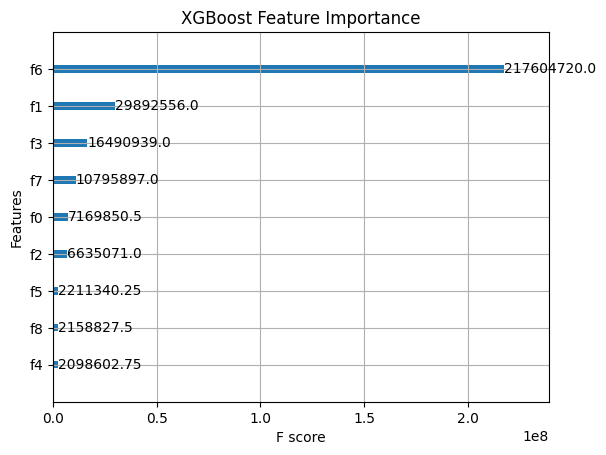

100%|===================| 63997/64122 [02:19<00:00]        

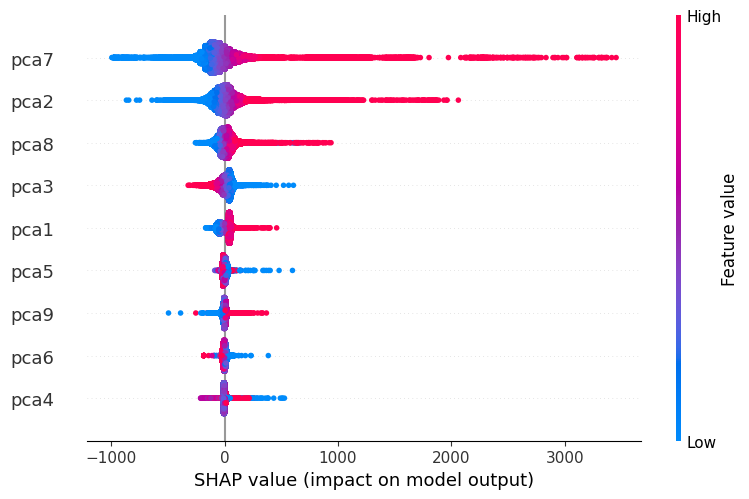

In [14]:
import shap
import matplotlib.pyplot as plt
import xgboost as xgb
import pandas as pd

# XGBoost Feature Importance
xgb.plot_importance(xgb_best, importance_type='gain', max_num_features=10)
plt.title("XGBoost Feature Importance")
plt.show()

if not isinstance(X_train_reg, pd.DataFrame):
    X_train_reg = pd.DataFrame(X_train_reg, columns=features) 
    
# Take 10% random sample from X_train
X_sample = X_train_reg.sample(frac=0.1, random_state=42)  # random_state for reproducibility

# Create SHAP explainer with sampled data
explainer = shap.TreeExplainer(xgb_best, X_sample)
shap_values = explainer.shap_values(X_sample)

# SHAP Summary Plot
shap.summary_plot(shap_values, X_sample)

shap.initjs()
# SHAP Force Plot for first prediction (Expected Value for Regression)
shap.force_plot(explainer.expected_value, shap_values[0], X_sample.iloc[0, :])

  Feature  SHAP Importance
6    pca7       151.116128
1    pca2        85.490906
7    pca8        46.665971
2    pca3        43.591741
0    pca1        41.916883
4    pca5        12.242554
8    pca9        11.329814
5    pca6        10.651191
3    pca4         9.289903


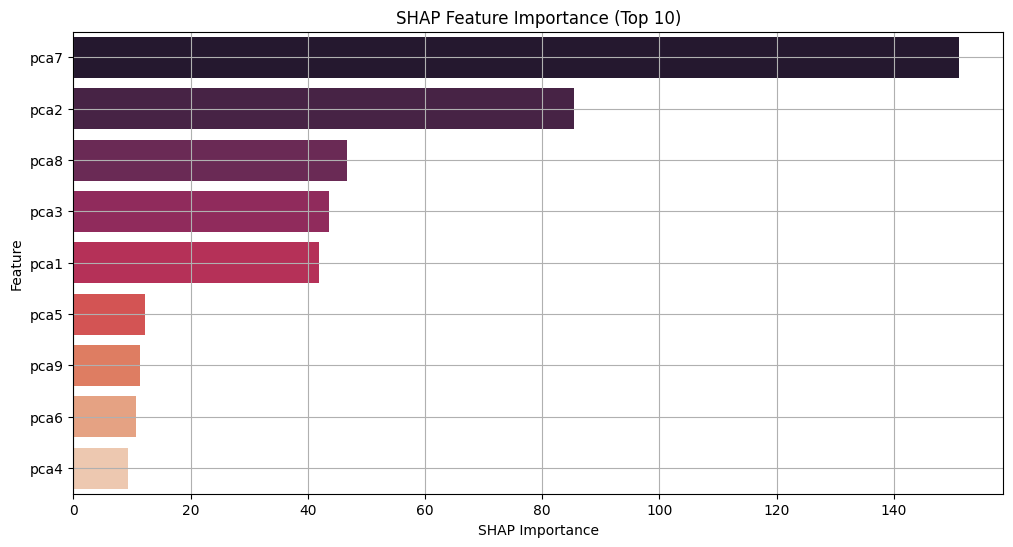

In [15]:
import seaborn as sns

# Convert X_train to DataFrame if not already
# if not isinstance(X_train, pd.DataFrame):
#     X_train = pd.DataFrame(X_train, columns=features) 

# SHAP Feature Importance (Bar Plot)
shap_df = pd.DataFrame({
    "Feature": X_train_reg.columns,
    "SHAP Importance": np.abs(shap_values).mean(axis=0)
})

if not isinstance(X_train_reg, pd.DataFrame):
    X_train_reg = pd.DataFrame(X_train_reg, columns = feature_names) #feature_names is a list of the column names.

shap_df = shap_df.sort_values(by="SHAP Importance", ascending=False)
print(shap_df.head(10))

plt.figure(figsize=(12, 6))
sns.barplot(x="SHAP Importance", y="Feature", data=shap_df.head(10), palette="rocket", hue="Feature", legend=False)
plt.title("SHAP Feature Importance (Top 10)")
plt.grid(True)
plt.show()

##### Key Observations for ETA Prediction:

In [16]:
# Feature SHAP Importance Interpretation
# pickup_time_delay	193.68	The most critical factor — any delay at the pickup stage significantly impacts the ETA.
# speed_kmh	37.20	Slower driving speeds increase ETA — highly influenced by traffic conditions.
# pickup_distance_km	35.14	Longer distances naturally increase ETA, but its impact is lower than pickup delays.
# hour_of_day	2.25	Certain hours (peak traffic hours like morning or evening) increase ETA.
# city_order_count	1.15	Higher demand in the city likely causes longer waiting times and affects the overall ETA.
# pickup_order_count	0.80	More pickups nearby may result in driver unavailability and longer waiting times.
# avg_pickup_time_minutes	0.68	Higher average pickup times directly increase ETA.
# day_of_week	0.67	Certain days (like weekends or holidays) might show longer ETAs due to higher order volumes.
# month	0.26	Seasonality impact — delays may be longer in holiday seasons or bad weather months.
# cluster	0.19	Some areas (high traffic or remote locations) may consistently have longer ETAs.

##### Hyperparameter Tuning for Random Forest

In [48]:
# 1. Define the Random Forest model
rf = RandomForestRegressor(featuresCol="features_eta", labelCol="pickup_eta_minutes")

# 2. Define hyperparameter grid
rf_param_grid = (ParamGridBuilder()
                 .addGrid(rf.numTrees, [50, 100])  # Number of trees
                 .addGrid(rf.maxDepth, [5, 10])  # Tree depth
                 .addGrid(rf.minInstancesPerNode, [2, 5])  # Min instances per node
                 .build())

# 3. Define evaluator
rf_evaluator = RegressionEvaluator(labelCol="pickup_eta_minutes", predictionCol="prediction", metricName="rmse")

# 4. Use CrossValidator with the validation set
rf_cv = CrossValidator(estimator=rf, 
                       estimatorParamMaps=rf_param_grid, 
                       evaluator=rf_evaluator, 
                       numFolds=3,  # 3-Fold Cross Validation using `val_reg`
                       parallelism=2)  # Adjust parallelism based on available cores

# 5. Fit the model using train_reg
rf_best_model = rf_cv.fit(train_reg)

# 6. Predict on test data
rf_tuned_predictions = rf_best_model.transform(test_reg)

# 7. Evaluate performance
evaluate_regression(rf_tuned_predictions, "Random Forest (Tuned)")

Random Forest (Tuned) - RMSE: 372.9424, R2: 0.1722, MSE: 139086.0114, MAE: 167.1475


##### Hyperparameter Tuning for Linear Regression

In [54]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Define Linear Regression model
lr = LinearRegression(featuresCol="features_eta", labelCol="pickup_eta_minutes")

# Define hyperparameter grid
lr_param_grid = (ParamGridBuilder()
                 .addGrid(lr.regParam, [0.01, 0.1, 0.5, 1.0])  # L2 regularization
                 .addGrid(lr.elasticNetParam, [0.0, 0.1, 0.3, 0.5, 0.7, 1.0])  # 0 = Ridge, 1 = Lasso
                 .build())

# Define evaluator
lr_evaluator = RegressionEvaluator(labelCol="pickup_eta_minutes", predictionCol="prediction", metricName="rmse")

# Define Cross Validator (performs internal validation)
lr_cv = CrossValidator(estimator=lr, estimatorParamMaps=lr_param_grid, evaluator=lr_evaluator, numFolds=3)

# Fit the model on training data (train_reg)
lr_best_model = lr_cv.fit(train_reg)

# Predict on validation set
val_predictions = lr_best_model.transform(val_reg)

# Evaluate on validation set
val_rmse = lr_evaluator.evaluate(val_predictions)
print(f"Validation RMSE: {val_rmse}")

# Predict on test set (only after validation)
lr_tuned_predictions = lr_best_model.transform(test_reg)

# Evaluate final model on test data
evaluate_regression(lr_tuned_predictions, "Linear Regression (Tuned)")

Validation RMSE: 389.29952014936356
Linear Regression (Tuned) - RMSE: 401.4123, R2: 0.0410, MSE: 161131.8621, MAE: 190.8792


In [51]:
# Validation RMSE: 389.29952014936356
# Linear Regression (Tuned) - RMSE: 401.4123, R2: 0.0410, MSE: 161131.8621, MAE: 190.8792
# looking at validation RMSE is 389.30, but test RMSE is 401.41, which indicates the model did not generalize well on unseen data.
# Possible Issues & Fixes Overfitting on Validation Set: If the validation RMSE is much lower than the test RMSE, the model might have memorized the validation data.
# Fix: Try increasing numFolds=5 in CrossValidator to make tuning more robust.
# Feature Scaling / Transformation: Linear Regression is sensitive to scaling: Fix: Try StandardScaler or MinMaxScaler on features_eta before training.
# Hperparameter Tweaks: elasticNetParam is very wide [0.0, 0.2, 0.5, 0.7, 1.0] : Fix: Try finer tuning (e.g., [0.0, 0.1, 0.3, 0.5, 0.7]).
# Model Selection: Linear Regression assumes a linear relationship. If relationships are non-linear, it's not the best choice.

##### Hyperparameter Tuning & Evaluation for XGBOOST – Optimizing model performance.

In [57]:
from xgboost.spark import SparkXGBRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Define XGBoost model
xgb = SparkXGBRegressor(features_col="features_eta", label_col="pickup_eta_minutes", num_workers=2)

# Define hyperparameter grid
xgb_param_grid = (ParamGridBuilder()
                  .addGrid(xgb.max_depth, [3, 5, 7])  # Tree depth
                  .addGrid(xgb.learning_rate, [0.01, 0.05])  # Learning rate (eta)
                  .addGrid(xgb.n_estimators, [100, 200])  # Boosting rounds (num_round)
                  .addGrid(xgb.subsample, [0.5, 0.7])  # Fraction of training data per round
                  .build())

# Define evaluator
xgb_evaluator = RegressionEvaluator(labelCol="pickup_eta_minutes", predictionCol="prediction", metricName="rmse")

# Define Cross Validator (uses train_reg for hyperparameter tuning)
xgb_cv = CrossValidator(estimator=xgb, estimatorParamMaps=xgb_param_grid, evaluator=xgb_evaluator, numFolds=3)

# Fit the model on training data
xgb_best_model = xgb_cv.fit(train_reg)

# Predict on validation set
val_predictions = xgb_best_model.transform(val_reg)

# Evaluate on validation set
val_rmse = xgb_evaluator.evaluate(val_predictions)
print(f"Validation RMSE: {val_rmse}")

# Predict on test set (only if validation RMSE is acceptable)
xgb_tuned_predictions = xgb_best_model.transform(test_reg)

# Evaluate final model on test data
evaluate_regression(xgb_tuned_predictions, "XGBoost (Tuned)")

2025-03-22 12:39:12,630 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 2 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.01, 'max_depth': 3, 'objective': 'reg:squarederror', 'subsample': 0.5, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-03-22 12:39:31,278 INFO XGBoost-PySpark: _fit Finished xgboost training!
2025-03-22 12:39:36,398 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 2 workers with
	booster params: {'device': 'cpu', 'learning_rate': 0.01, 'max_depth': 3, 'objective': 'reg:squarederror', 'subsample': 0.7, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2025-03-22 12:39:43,080 INFO XGBoost-PySpark: _fit Finished xgboost training!
2025-03-22 12:39:45,814 INFO XGBoost-PySpark: _fit Running xgboost-2.1.4 on 2 workers with
	booster params: {'device': 'cpu', 'learning_rate

Validation RMSE: 356.04595390276165
XGBoost (Tuned) - RMSE: 367.1709, R2: 0.1977, MSE: 134814.4910, MAE: 162.3929


In [ ]:
Linear Regression - RMSE: 401.4263, R2: 0.0410, MSE: 161143.0812, MAE: 190.8967
Random Forest - RMSE: 384.2944, R2: 0.1211, MSE: 147682.2104, MAE: 176.1925
XGBoost - RMSE: 369.0526, R2: 0.1894, MSE: 136199.8548, MAE: 162.6161

In [59]:
# Show Sample Predictions
xgb_tuned_predictions.select("pickup_eta_minutes", "prediction").show(10, truncate=False)


+------------------+------------------+
|pickup_eta_minutes|prediction        |
+------------------+------------------+
|83.0              |283.0155944824219 |
|125.0             |295.8624267578125 |
|85.0              |265.32940673828125|
|64.0              |268.5245361328125 |
|175.0             |265.3459167480469 |
|223.0             |228.24794006347656|
|194.0             |273.3114013671875 |
|194.0             |269.8323669433594 |
|197.0             |291.4444885253906 |
|185.0             |473.31494140625   |
+------------------+------------------+
only showing top 10 rows



In [60]:
from pyspark.sql.functions import col

# Replace 'column_name' with your actual column name
negative_count = xgb_tuned_predictions.filter(col("prediction") < 0).count()

print(f"Number of negative values in column 'prediction': {negative_count}")

Number of negative values in column 'prediction': 13


In [61]:
from pyspark.sql import functions as F
xgb_tuned_predictions = xgb_tuned_predictions.withColumn("prediction", F.when(F.col("prediction") < 0, 0).otherwise(F.col("prediction")))

In [62]:
from pyspark.sql.functions import col

# Replace 'column_name' with your actual column name
negative_count = xgb_tuned_predictions.filter(col("prediction") < 0).count()

print(f"Number of negative values in column 'prediction': {negative_count}")

Number of negative values in column 'prediction': 0


##### Save the Model as a Pickle

In [72]:
import pickle

# Extract the best XGBoost model from CrossValidatorModel
best_xgb_model = xgb_best_model.bestModel  # Extracting the best model

# Convert Spark XGBoost model to native XGBoost
native_xgb_model = best_xgb_model.get_booster()

# Save the native XGBoost model as a pickle file
with open("xgboost_model_pickup.pkl", "wb") as f:
    pickle.dump(native_xgb_model, f)

print("XGBoost model saved as 'xgboost_model.pkl'")


XGBoost model saved as 'xgboost_model.pkl'


##### Load Model for Future Predictions

In [75]:
import xgboost as xgb
import numpy as np

# Load the saved XGBoost model
with open("xgboost_model_pickup.pkl", "rb") as f:
    loaded_xgb_model = pickle.load(f)

# Example test data (must match the number of features in training)
test_sample = np.array([[12.5, 100, 30, 5.2, 60, 7, 3, 5, 200, 2]])

# Convert test data to DMatrix (XGBoost format)
dtest = xgb.DMatrix(test_sample)

# Make prediction
prediction = loaded_xgb_model.predict(dtest)

print("Predicted ETA:", prediction)

Predicted ETA: [133.11406]


#### Classification models for Delay detection (Logistic Regression, Decision Tree, Neural Networks)

In [79]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Define Models
log_reg = LogisticRegression(featuresCol="features_cls", labelCol="is_delayed_index")
dt = DecisionTreeClassifier(featuresCol="features_cls", labelCol="is_delayed_index")
mlp = MultilayerPerceptronClassifier(featuresCol="features_cls", labelCol="is_delayed_index", layers=[10, 5, 3])

# Train Models
log_reg_model = log_reg.fit(train_cls)
dt_model = dt.fit(train_cls)
mlp_model = mlp.fit(train_cls)

# Make Predictions
log_reg_predictions = log_reg_model.transform(test_cls)
dt_predictions = dt_model.transform(test_cls)
mlp_predictions = mlp_model.transform(test_cls)

# Define accuracy evaluator
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="is_delayed_index", metricName="accuracy")

# Evaluate and print accuracy
log_reg_accuracy = accuracy_evaluator.evaluate(log_reg_predictions)
dt_accuracy = accuracy_evaluator.evaluate(dt_predictions)
mlp_accuracy = accuracy_evaluator.evaluate(mlp_predictions)

print(f"Logistic Regression Accuracy: {log_reg_accuracy:.4f}")
print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")
print(f"Neural Network Accuracy: {mlp_accuracy:.4f}")

Logistic Regression Accuracy: 1.0000
Decision Tree Accuracy: 0.9996
Neural Network Accuracy: 0.7324


In [80]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Use `predictionCol="prediction"` for Binary Classification
auc_evaluator = BinaryClassificationEvaluator(labelCol="is_delayed_index", rawPredictionCol="prediction", metricName="areaUnderROC")

# Evaluate models
log_reg_auc = auc_evaluator.evaluate(log_reg_predictions)
dt_auc = auc_evaluator.evaluate(dt_predictions)
mlp_auc = auc_evaluator.evaluate(mlp_predictions)

print(f"Logistic Regression AUC: {log_reg_auc:.4f}")
print(f"Decision Tree AUC: {dt_auc:.4f}")
print(f"Neural Network AUC: {mlp_auc:.4f}")

Logistic Regression AUC: 1.0000
Decision Tree AUC: 0.9997
Neural Network AUC: 0.5000


##### Hyperparameter tuning for Logistic Regression¶


In [87]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define the Logistic Regression model
log_reg = LogisticRegression(featuresCol="features_cls", labelCol="is_delayed_index")

# Define the parameter grid for hyperparameter tuning
log_reg_param_grid = (ParamGridBuilder()
                      .addGrid(log_reg.regParam, [0.01, 0.1, 1.0])  # Regularization parameter
                      .addGrid(log_reg.elasticNetParam, [0.0, 0.5, 1.0])  # ElasticNet mixing
                      .addGrid(log_reg.maxIter, [10, 50, 100])  # Number of iterations
                      .build())

# Define evaluator using accuracy
log_reg_evaluator = MulticlassClassificationEvaluator(
    labelCol="is_delayed_index", predictionCol="prediction", metricName="accuracy"
)

# Perform cross-validation
log_reg_cv = CrossValidator(
    estimator=log_reg,
    estimatorParamMaps=log_reg_param_grid,
    evaluator=log_reg_evaluator,
    numFolds=3  # 3-fold cross-validation
)

# Fit the model
log_reg_cv_model = log_reg_cv.fit(train_cls)

# Get best model from CrossValidator
best_log_reg_model = log_reg_cv_model.bestModel

# Make predictions on test data
log_reg_predictions = best_log_reg_model.transform(test_cls)

# Evaluate accuracy
log_reg_accuracy = log_reg_evaluator.evaluate(log_reg_predictions)

print(f"Best Logistic Regression Model Accuracy: {log_reg_accuracy:.4f}")


Best Logistic Regression Model Accuracy: 0.9785


In [88]:
log_reg_predictions.groupBy("is_delayed_index").count().show()

+----------------+-----+
|is_delayed_index|count|
+----------------+-----+
|             0.0|46844|
|             1.0|17114|
+----------------+-----+



In [89]:
log_reg_predictions.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|48216|
|       1.0|15742|
+----------+-----+



In [90]:
log_reg_predictions.select("is_delayed_index", "prediction").show(10, truncate=False)

+----------------+----------+
|is_delayed_index|prediction|
+----------------+----------+
|1.0             |1.0       |
|1.0             |1.0       |
|1.0             |1.0       |
|1.0             |1.0       |
|1.0             |1.0       |
|1.0             |1.0       |
|1.0             |1.0       |
|1.0             |1.0       |
|1.0             |1.0       |
|1.0             |1.0       |
+----------------+----------+
only showing top 10 rows



##### Hyperparameter tuning of Decision Tree

In [91]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize Decision Tree Classifier
dt = DecisionTreeClassifier(featuresCol="features_cls", labelCol="is_delayed_index")

# Define hyperparameter grid
param_grid = (ParamGridBuilder()
              .addGrid(dt.maxDepth, [3, 5, 10])
              .addGrid(dt.minInstancesPerNode, [1, 5, 10])
              .addGrid(dt.impurity, ["gini", "entropy"])
              .build())

# Define Accuracy Evaluator
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="is_delayed_index", predictionCol="prediction", metricName="accuracy")

# Perform Cross Validation
crossval = CrossValidator(estimator=dt,
                          estimatorParamMaps=param_grid,
                          evaluator=accuracy_evaluator,  # Optimize for Accuracy
                          numFolds=3)  # 3-Fold Cross Validation

# Train Decision Tree with hyperparameter tuning
dt_model = crossval.fit(train_cls)

# Get the best model
best_dt = dt_model.bestModel

# Make predictions on test data
dt_predictions = best_dt.transform(test_cls)

# Compute Accuracy
dt_accuracy = accuracy_evaluator.evaluate(dt_predictions)

# Print Accuracy
print(f"Best Decision Tree Model Accuracy: {dt_accuracy:.4f}")

Best Decision Tree Model Accuracy: 0.9996


In [84]:
predictions.groupBy("is_delayed_index").count().show()

+----------------+------+
|is_delayed_index| count|
+----------------+------+
|             0.0|117369|
|             1.0| 42547|
+----------------+------+



In [92]:
predictions.groupBy("prediction").count().show()

+----------+------+
|prediction| count|
+----------+------+
|       0.0|120338|
|       1.0| 39578|
+----------+------+



In [87]:
predictions.select("is_delayed_index", "prediction").show(10, truncate=False)

+----------------+----------+
|is_delayed_index|prediction|
+----------------+----------+
|0.0             |0.0       |
|0.0             |0.0       |
|0.0             |0.0       |
|0.0             |0.0       |
|0.0             |0.0       |
|0.0             |0.0       |
|0.0             |0.0       |
|0.0             |0.0       |
|0.0             |0.0       |
|0.0             |0.0       |
+----------------+----------+
only showing top 10 rows



#### Hyperparameter Tuning for Neural Network

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler

# Feature Scaling (Keep Only Once to Avoid Multiple Fits)
scaler = StandardScaler(inputCol="features_cls", outputCol="scaled_features", withStd=True, withMean=False)
# scaled_model = scaler.fit(train_cls)
# train_cls = scaled_model.transform(train_cls)
# test_cls = scaled_model.transform(test_cls)

# Get Input Layer Size Dynamically
input_size = train_cls.select("scaled_features").first()["scaled_features"].size

# Define a Simplified Neural Network Model for Faster Training
mlp = MultilayerPerceptronClassifier(featuresCol="scaled_features", labelCol="is_delayed_index",
                                     maxIter=50,  # Reduced from 150 → 50
                                     blockSize=256,  # Larger block size for efficiency
                                     seed=42)

# Define a Simpler Hyperparameter Grid
param_grid = (ParamGridBuilder()
              .addGrid(mlp.layers, [[input_size, 16, 2], [input_size, 32, 2]])  # Reduced layer complexity
              .addGrid(mlp.stepSize, [0.01, 0.05])  # Fewer learning rates
              .build())

# Define Accuracy Evaluator
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="is_delayed_index", metricName="accuracy")

# Perform **2-Fold Cross Validation (Faster)**
crossval = CrossValidator(estimator=mlp,
                          estimatorParamMaps=param_grid,
                          evaluator=accuracy_evaluator,  
                          numFolds=2)  # Changed from 3-Fold to 2-Fold

# Train Neural Network with Optimized Parameters
mlp_model = crossval.fit(train_cls)

# Get the Best Model
best_mlp = mlp_model.bestModel

# Make Predictions on Test Data
mlp_predictions = best_mlp.transform(test_cls)

# Compute Accuracy
mlp_accuracy = accuracy_evaluator.evaluate(mlp_predictions)

# Print Best Model Accuracy
print(f"Best Neural Network Model Accuracy: {mlp_accuracy:.4f}")

In [100]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# Define evaluators
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="is_delayed_index", metricName="accuracy")
precision_evaluator = MulticlassClassificationEvaluator(labelCol="is_delayed_index", metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(labelCol="is_delayed_index", metricName="weightedRecall")
auc_evaluator = BinaryClassificationEvaluator(labelCol="is_delayed_index", rawPredictionCol="prediction", metricName="areaUnderROC")

# Compute metrics for Decision Tree
dt_accuracy = accuracy_evaluator.evaluate(dt_predictions)
dt_precision = precision_evaluator.evaluate(dt_predictions)
dt_recall = recall_evaluator.evaluate(dt_predictions)
dt_auc = auc_evaluator.evaluate(dt_predictions)

# Compute metrics for Logistic Regression
log_reg_accuracy = accuracy_evaluator.evaluate(log_reg_predictions)
log_reg_precision = precision_evaluator.evaluate(log_reg_predictions)
log_reg_recall = recall_evaluator.evaluate(log_reg_predictions)
log_reg_auc = auc_evaluator.evaluate(log_reg_predictions)

# Compute metrics for Neural Network
nn_accuracy = accuracy_evaluator.evaluate(mlp_predictions)
nn_precision = precision_evaluator.evaluate(mlp_predictions)
nn_recall = recall_evaluator.evaluate(mlp_predictions)
nn_auc = auc_evaluator.evaluate(mlp_predictions)

# Print results
print(f"Decision Tree - Accuracy: {dt_accuracy:.4f}, Precision: {dt_precision:.4f}, Recall: {dt_recall:.4f}, AUC: {dt_auc:.4f}")
print(f"Logistic Regression - Accuracy: {log_reg_accuracy:.4f}, Precision: {log_reg_precision:.4f}, Recall: {log_reg_recall:.4f}, AUC: {log_reg_auc:.4f}")
print(f"Neural Network - Accuracy: {nn_accuracy:.4f}, Precision: {nn_precision:.4f}, Recall: {nn_recall:.4f}, AUC: {nn_auc:.4f}")

Decision Tree - Accuracy: 0.9996, Precision: 0.9996, Recall: 0.9996, AUC: 0.9997
Logistic Regression - Accuracy: 0.9785, Precision: 0.9792, Recall: 0.9785, AUC: 0.9599
Neural Network - Accuracy: 0.7324, Precision: 0.5364, Recall: 0.7324, AUC: 0.5000


##### Save the Model

In [ ]:
# # Set the threshold to 0.25 before saving
# best_lr.setThreshold(0.25)

# delay_model = "classification_model_pickup"
# best_lr.write().overwrite().save(delay_model)
# print(f"Model saved at {delay_model}")

In [93]:
import pickle
import numpy as np
from sklearn.linear_model import LogisticRegression

# Set threshold before saving (Applies only in Spark, not in Sklearn)
# best_lr.setThreshold(0.25)

# Convert Spark Logistic Regression Model to Sklearn
sklearn_lr_model = LogisticRegression()
sklearn_lr_model.coef_ = np.array(best_lr.coefficients).reshape(1, -1)
sklearn_lr_model.intercept_ = np.array([best_lr.intercept])

# Manually Assign Classes
sklearn_lr_model.classes_ = np.array(["On Time", "Delayed"])  

# Save as Pickle
delay_model_path = "delay_model_pickup.pkl"
with open(delay_model_path, "wb") as f:
    pickle.dump(sklearn_lr_model, f)

print(f"Model saved as {delay_model_path}")

Model saved as delay_model_pickup.pkl


##### Load Model for Future Predictions

In [ ]:
from pyspark.ml.classification import LogisticRegressionModel

# Load the saved model
with open("delay_model_pickup.pkl", "rb") as f:
    loaded_lr = pickle.load(f)

# Check if the threshold is correctly set
print(f"Loaded Model Threshold: {loaded_lr.getThreshold()}")  # Should print 0.25

# Make predictions using the saved model with the adjusted threshold
new_predictions = loaded_lr.transform(test_cls)

# Show sample predictions
new_predictions.select("is_delayed_index", "prediction").show(10)

AttributeError: 'LogisticRegression' object has no attribute 'getThreshold'